#**Introduction and Overview**

**Model Description**

The model we developed is an audio classifier based on deep neural networks.

This model is trained to recognize and classify bird calls based on their unique acoustic characteristics. Using audio recordings, the model can identify the bird species corresponding to a given song or call.

**Assessment Objectives**

The main objective of the evaluation is to measure the effectiveness and accuracy of our model in the real-world context. This includes:

Evaluate the model's ability to generalize to previously unseen data.

Identify key performance metrics, such as accuracy, precision, recall, and F1 score.

Analyze the model's predictions to better understand its strengths and areas for improvement.

Provide a basis for further model development and optimization.

Throughout this evaluation, we will focus on these aspects, using a test dataset that includes a variety of audio recordings from different birds. Through this analysis, we aim to establish the robustness and reliability of our bird audio classification model.

#**Data Preparation**

In the phase of preparing data for evaluation, audio files are initially loaded and transformed into spectrograms, which are visual representations of frequencies over time, to suit analysis.

This process involves splitting audio signals into shorter segments, typically of fixed length, for more efficient handling.
Each segment is then converted into a spectrogram through the Mel transform, a technique that adapts the representation of sound to human perceptions of frequencies.

The resulting data is normalized for consistency and converted to a format compatible with the model. This includes scaling the spectrograms to the required dimensions and organizing them along with the corresponding labels for further model evaluation.

This thorough preparation is critical to ensuring that the model receives consistent and representative data for effective evaluation.

In [ ]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
import os
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import librosa
import numpy as np
import pickle

from sklearn.utils import shuffle
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow_addons.metrics import F1Score





In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Global vars
RANDOM_SEED = 1337
SAMPLE_RATE = 32000
SIGNAL_LENGTH = 5 # seconds
SPEC_SHAPE = (48, 128) # height x width
FMIN = 500
FMAX = 12500
# MAX_AUDIO_FILES = 10000
EPOCHS=50

In [ ]:

audio_base_dir = '/content/gdrive/MyDrive/DsiM70/Dataset_TEST'

test_data = []
for folder_name in os.listdir(audio_base_dir):
    sub_folder = os.path.join(audio_base_dir, folder_name)
    if os.path.isdir(sub_folder):
        for file_name in os.listdir(sub_folder):
            if file_name.endswith('.ogg'):
                test_data.append({'nome_file': file_name, 'label': folder_name})

TEST = pd.DataFrame(test_data)

print(f"Numero di campioni di test: {len(TEST)}")




Numero di campioni di test: 50


In [ ]:
LABELS = sorted(TEST['label'].unique())

In [ ]:
print('NUMBER OF SPECIES IN TRAIN DATA:', len(LABELS))
print('NUMBER OF SAMPLES IN TRAIN DATA:', len(TEST))

NUMBER OF SPECIES IN TRAIN DATA: 25
NUMBER OF SAMPLES IN TRAIN DATA: 50


In [ ]:
# saving labels
with open('LABELS.pkl','wb') as f:
    pickle.dump(LABELS,f)

In [ ]:

def get_spectrograms(filepath, primary_label, output_dir):

    sig, rate = librosa.load(filepath, sr=SAMPLE_RATE, offset=None, duration=15)

    sig_splits = []
    for i in range(0, len(sig), int(SIGNAL_LENGTH * SAMPLE_RATE)):
        split = sig[i:i + int(SIGNAL_LENGTH * SAMPLE_RATE)]

        if len(split) < int(SIGNAL_LENGTH * SAMPLE_RATE):
            break

        sig_splits.append(split)

    s_cnt = 0
    saved_samples = []
    for chunk in sig_splits:

        hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
        mel_spec = librosa.feature.melspectrogram(y=chunk,
                                                  sr=SAMPLE_RATE,
                                                  n_fft=1024,
                                                  hop_length=hop_length,
                                                  n_mels=SPEC_SHAPE[0],
                                                  fmin=FMIN,
                                                  fmax=FMAX)

        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()

        save_dir = os.path.join(output_dir, primary_label)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, filepath.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0] +
                                 '_' + str(s_cnt) + '.png')
        im = Image.fromarray(mel_spec * 255.0).convert("L")
        im.save(save_path)

        saved_samples.append(save_path)
        s_cnt += 1


    return saved_samples

print('FINAL NUMBER OF AUDIO FILES IN TRAINING DATA:', len(TEST))

FINAL NUMBER OF AUDIO FILES IN TRAINING DATA: 50


In [ ]:
def extend_with_zeros(sig, target_length):
    padding = target_length - len(sig)
    if padding > 0:
        sig = np.pad(sig, (0, padding), 'constant')
    return sig


In [ ]:
def get_spectrogram_center(filepath, primary_label, output_dir):
    sig, rate = librosa.load(filepath, sr=SAMPLE_RATE)
    center = len(sig) // 2  # Punto centrale del segnale
    start = max(0, center - (SAMPLE_RATE * SIGNAL_LENGTH) // 2)  # Inizio del segmento
    end = min(len(sig), center + (SAMPLE_RATE * SIGNAL_LENGTH) // 2)  # Fine del segmento
    sig = sig[start:end]  # Estrazione del segmento

    # Estensione del segnale con zeri se è più corto di 5 secondi
    sig = extend_with_zeros(sig, SAMPLE_RATE * SIGNAL_LENGTH)
    # Generazione dello spettrogramma
    hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
    mel_spec = librosa.feature.melspectrogram(y=sig,
                                              sr=SAMPLE_RATE,
                                              n_fft=1024,
                                              hop_length=hop_length,
                                              n_mels=SPEC_SHAPE[0],
                                              fmin=FMIN,
                                              fmax=FMAX)

    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec -= mel_spec.min()
    mel_spec /= mel_spec.max()

    # Salvataggio dello spettrogramma
    save_dir = os.path.join(output_dir, primary_label)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, filepath.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0] + '.png')
    im = Image.fromarray(mel_spec * 255.0).convert("L")
    im.save(save_path)

    return [save_path]


In [ ]:
from tqdm import tqdm
from sklearn.utils import shuffle

test_output_dir = '/content/gdrive/MyDrive/DsiM70/Dataset_finale_Spettrogrammi_TEST3'
test_samples = []
with tqdm(total=len(TEST)) as pbar:
    for idx, row in TEST.iterrows():
        pbar.update(1)
        audio_file_path = os.path.join(audio_base_dir, row['label'], row['nome_file'])
        test_samples += get_spectrogram_center(audio_file_path, row['label'], test_output_dir)

TEST_SPECS = shuffle(test_samples, random_state=RANDOM_SEED)
print('SUCCESSFULLY EXTRACTED {} SPECTROGRAMS FOR TESTING'.format(len(TEST_SPECS)))



100%|██████████| 50/50 [00:22<00:00,  2.23it/s]

SUCCESSFULLY EXTRACTED 50 SPECTROGRAMS FOR TESTING


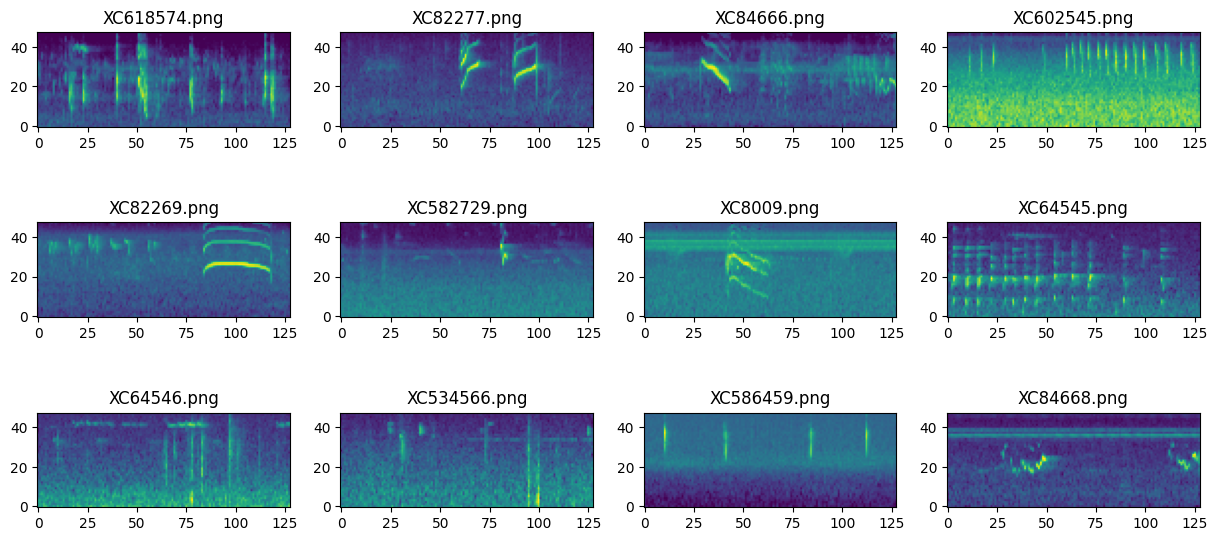

In [ ]:
plt.figure(figsize=(15, 7))
for i in range(12):
    spec = Image.open(TEST_SPECS[i])
    plt.subplot(3, 4, i + 1)
    plt.title(TEST_SPECS[i].split(os.sep)[-1])
    plt.imshow(spec, origin='lower')

**3. Caricamento del Modello**

In [ ]:
from keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
model = load_model('/content/gdrive/MyDrive/DsiM70/modello.h5')

#**Model Evaluation**

In [ ]:

test_specs, test_labels = [], []
with tqdm(total=len(TEST_SPECS)) as pbar:
    for path in TEST_SPECS:
        pbar.update(1)

        spec = Image.open(path)

        spec = np.array(spec, dtype='float32')


        spec -= spec.min()
        spec /= spec.max()
        if not spec.max() == 1.0 or not spec.min() == 0.0:
            continue

        spec = np.expand_dims(spec, -1)

        spec = np.expand_dims(spec, 0)

        if len(test_specs) == 0:
            test_specs = spec
        else:
            test_specs = np.vstack((test_specs, spec))

        target = np.zeros((len(LABELS)), dtype='float32')
        bird = path.split(os.sep)[-2]
        target[LABELS.index(bird)] = 1.0
        if len(test_labels) == 0:
            test_labels = target
        else:
            test_labels = np.vstack((test_labels, target))




100%|██████████| 50/50 [00:00<00:00, 596.12it/s]


In [ ]:
predictions = model.predict(test_specs)
predicted_classes = np.argmax(predictions, axis=1)

2/2 [==============================] - 3s 217ms/step


#**Viewing Results**


In [ ]:
actual_classes = np.argmax(test_labels, axis=1)


In [ ]:
comparison_table = pd.DataFrame({
    'Audio': [path.split(os.sep)[-1] for path in TEST_SPECS],
    'Classe Reale': [LABELS[class_idx] for class_idx in actual_classes],
    'Classe Predetta': [LABELS[class_idx] for class_idx in predicted_classes]
})

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(actual_classes, predicted_classes)
print(f"Accuratezza del modello: {accuracy * 100:.2f}%")


Accuratezza del modello: 60.00%


The model achieved an accuracy of 60.00% in predicting test audios. This result could be further improved by increasing the number of audio files used for training. However, due to the limitations of the available devices, this is the best result we have been able to achieve.

In [ ]:
comparison_table

,Audio,Classe Reale,Classe Predetta
0,XC618574.png,yehbla,yehbla
1,XC82277.png,strfly1,bnhcow
2,XC84666.png,butsal1,butsal1
3,XC602545.png,yelwar,yelwar
4,XC82269.png,rumfly1,rumfly1
5,XC582729.png,blkpho,eastow
6,XC8009.png,roahaw,roahaw
7,XC64545.png,pilwoo,pilwoo
8,XC64546.png,pilwoo,sumtan
9,XC534566.png,ducfly,roahaw


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(actual_classes, predicted_classes))
conf_mat = confusion_matrix(actual_classes, predicted_classes)




              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      0.50      0.67         2
           2       0.50      1.00      0.67         2
           3       0.00      0.00      0.00         2
           4       0.67      1.00      0.80         2
           5       1.00      0.50      0.67         2
           6       1.00      0.50      0.67         2
           7       0.50      1.00      0.67         2
           8       0.00      0.00      0.00         2
           9       0.50      0.50      0.50         2
          10       1.00      1.00      1.00         2
          11       1.00      0.50      0.67         2
          12       1.00      0.50      0.67         2
          13       1.00      0.50      0.67         2
          14       0.67      1.00      0.80         2
          15       0.50      1.00      0.67         2
          16       1.00      1.00      1.00         2
          17       0.00    

The results presented show the performance of a classification model on a total of 25 classes (indexed from 0 to 24), evaluated in terms of precision, recall and F1 score, as well as the amount of support (number of samples) for each class.

- **Precision:**

High precision (1.00) is observed in classes 0, 1, 5, 6, 10, 11, 12, 13, 16, which indicates a high accuracy in predicting these classes correctly.
The lowest precision is observed in classes 3, 8, 17, 18, with a value of 0.00, suggesting the model's predictions for these classes are often incorrect.

- **Recall:**

Perfect recall (1.00) is noted in classes 2, 4, 7, 10, 14, 15, 16, 21, 23, 24, indicating the model correctly identified all true positives for these classes.
Classes 3, 8, 17, 18, 22 show the lowest recall (0.00), meaning the model missed all true positives for these classes.

- **F1-Score**:

The F1 score is highest for classes 4, 10, 14, 16, 23, 24, indicating a good balance between precision and recall for these classes.
The lowest F1 scores are for classes 3, 8, 17, 18, 22, suggesting a combination of low precision and recall for these classes.

- **Support**:

The number of real samples (support) per class varies, with each class having 2 samples in the dataset.

- **Global Accuracy**:

The overall accuracy of the model is 60%, indicating that it correctly classified the input in 60% of cases.

- **Macro and Weighted Average**:

The macro average and weighted average for precision, recall, and F1-score are all around 60%, showing the overall performance across all classes.

In summary, the model shows variation in performance between different classes, with some classes classified well and others with large room for improvement. The overall accuracy indicates a moderate level of classification ability, but with room for further optimization.

#**Error Analysis**


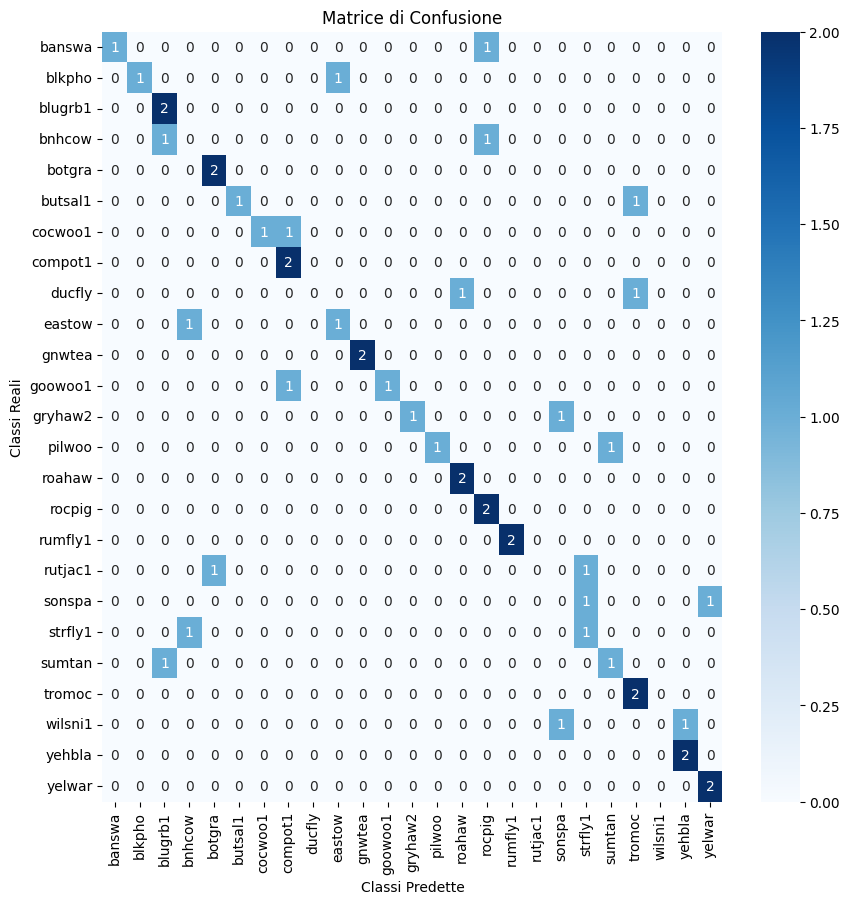

Numero di errori: 20


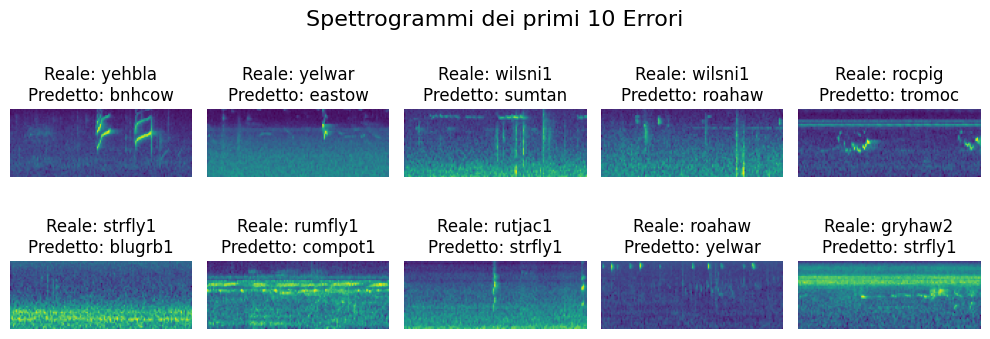

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(actual_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues')
plt.title('Matrice di Confusione')
plt.xlabel('Classi Predette')
plt.ylabel('Classi Reali')


plt.xticks(ticks=np.arange(len(LABELS)) + 0.5, labels=LABELS, rotation=90)
plt.yticks(ticks=np.arange(len(LABELS)) + 0.5, labels=LABELS, rotation=0)

plt.show()

errors = np.where(predicted_classes != actual_classes)[0]
print("Numero di errori:", len(errors))

spec_size = (2, 2)


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
fig.suptitle('Spettrogrammi dei primi 10 Errori', fontsize=16)
axes = axes.flatten()

for i, error in enumerate(errors[:10]):
    real_species = LABELS[true_classes[error]]
    predicted_species = LABELS[predicted_classes[error]]
    spec = Image.open(TEST_SPECS[error])

    axes[i].imshow(spec, origin='lower')
    axes[i].set_title(f"Reale: {real_species}\nPredetto: {predicted_species}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()




Thanks to the confusion matrix we can observe how the model classified the real classes or not, knowing that having inserted two audios as tests for each real class, the optimal result would have been to observe the value two along the entire diagonal of the map. Instead, as can be understood from a first glance, the model still presents many classification errors.
In particular we observe:
- **5 classes classified always incorrect**, have the value 0 on the diagonal
- **10 classes classified always correct**, have the value 2 on the diagonal
- **10 classes classified once correctly and once incorrectly**
No particular patterns of errors are detected where, for example, the model classifies two classes incorrectly with each other.



# **Conclusion and Reflections**

In summary, the current model achieved an accuracy of 60.00%, showing moderate proficiency in correctly identifying bird species through their song. The model excels at identifying some species, as demonstrated by high precision and recall scores in certain categories. Despite this, there is room for improvement, considering the percentage of correct classifications is not optimal.

The observed shortcomings could arise from a number of factors, including the diversity and quality of the training data and the inherent ability of the model to distinguish distinctive features.

To advance and refine the model's capabilities, several strategies could be explored:
- **Dataset Expansion**: Addition of additional audio samples, especially for categories that showed the most confusion.
- **Data Augmentation**: Implementation of augmentation methods to enrich the variety of training data, potentially improving the model's ability to generalize.
- **Hyperparameter Tuning**: Refinement of model hyperparameters to optimize performance, for example by modifying the structure or activation functions.
- **Ensemble Learning**: Using an ensemble approach, combining predictions from multiple models to increase overall accuracy and stability.
- **Post-Prediction Processing**: Introduction of post-processing techniques to interpret the results, such as considering the correlation between successive audio segments.

This promising starting point suggests that there is considerable potential for model evolution needed to address the complex challenges of classifying natural sounds.